# HW4-Kenwan

### GOAL: Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments

### Details:

1. Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors/ Discard the text from “Health Code” – only keep inspectors’ comments.
2. Build classification model, predicting the outcome of inspection – your target variable is “Results”
3. Explain why you selected a particular text pre-processing technique
4. Visualize results of at least two text classifiers and select the most robust one. You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

In [230]:
#IMPORT
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [4]:
# import csv
fi = pd.read_csv('../raw-dontadd/Food_Inspections.csv')

In [5]:
fi.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2144467,MEHRAB SUPERMARKET,MEHRAB,2578159.0,Grocery Store,Risk 2 (Medium),2433 W DEVON AVE,CHICAGO,IL,60659.0,02/02/2018,License Re-Inspection,Pass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.997599,-87.691163,"(41.99759944782518, -87.69116270116571)"
1,2144446,NEW AGE PREP ACADEMY INC.,NEW AGE PREP ACADEMY,2298350.0,Daycare (2 - 6 Years),Risk 1 (High),5124-26 S WESTERN AVE,CHICAGO,IL,60609.0,02/02/2018,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.800379,-87.684351,"(41.80037873158603, -87.68435083477779)"
2,2144442,SUBWAY,SUBWAY,1904894.0,Restaurant,Risk 1 (High),1300 S WABASH AVE,CHICAGO,IL,60605.0,02/02/2018,Recent Inspection,Pass,NaN,41.865676,-87.625944,"(41.8656758723776, -87.625943531346)"
3,2144440,SCHUBA'S TAVERN/TIED HOUSE,SCHUBA'S TAVERN,2549712.0,Restaurant,Risk 1 (High),3153-3159 N SOUTHPORT AVE,CHICAGO,IL,60657.0,02/02/2018,License Re-Inspection,Pass,NaN,41.939534,-87.663666,"(41.939533581366824, -87.66366619417107)"
4,2144438,SCHUBA'S TAVERN/TIED HOUSE,SCHUBA'S TAVERN,2549711.0,Restaurant,Risk 1 (High),3153-3159 N SOUTHPORT AVE,CHICAGO,IL,60657.0,02/02/2018,License Re-Inspection,Pass,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.939534,-87.663666,"(41.939533581366824, -87.66366619417107)"


In [36]:
# let's extract just the results
fail = fi[["Results","Violations"]]
# fail = fail.Violations

In [37]:
fail.head()

,Results,Violations
0,Pass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...
1,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
2,Pass,NaN
3,Pass,NaN
4,Pass,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D..."


In [38]:
fail = fail[fail.Violations.notnull()]
fail = fail.reset_index(drop=True)

In [39]:
fail.head()

,Results,Violations
0,Pass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...
1,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
2,Pass,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D..."
3,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D..."
4,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...


### In parsing the comments, I noticed there were line breaks introduced with pandas

We regex them out below

In [21]:
# replace line breaks
fail.replace({r'\n\s\n': ''}, regex=True,inplace=True)

## We've now imported the violations again and segmented out the failures

However we are looking for the individual comments, so we need to tweak the parsing.

In [90]:
fail.Violations.loc[0]

'2. FACILITIES TO MAINTAIN PROPER TEMPERATURE - Comments: COOLER NOW OPERATING AT THE PROPER TEMPERATURE OF 39F. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: ALL ENTRANCE/EXIT DOORS ARE NOW PROPERLY SEALED. ALL MICE DROPPINGS HAVE BEEN REMOVED. | 24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED - Comments: PROPER NOZZLE ON THE THREE COMPARTMENT SINK THAT REACHES ALL THREE COMPARTMENTS AND NO LONGER LEAKS. | 31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE ARTICLES PROPERLY STORED: NO REUSE OF SINGLE SERVICE ARTICLES - Comments: VIOLATION CORRECTED. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: VIOLATION CORRECTED. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: VIOLATION CORRECTED. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED

In [88]:
fail.Violations.loc[1]

'18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: Observed mouse droppings in the following areas: approximately 10 dropping at top of basement stairs; 10 on floors in corner or dry storage room; 10 inside closet inside dry storage room; and 5 inside utility closet in hallway. Must remove droppings, clean and sanitize all areas. Must eliminate pest issue. Serious 7-38-020. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: Observed large hole in the wall under utility sink inside utility closet in the hallway. Observed hole in ceiling in hallway next to kitchen area. Must seal holes to prevent pest entry. Must maintain same.  | 41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED - Comments: Observed excessive clutter in the closet in the dry storage room. Mu

In [89]:
fail.Violations.loc[2]

'11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED - Comments: EXPOSED HAND SINK WITH SPLASH GUARDS INSTALLED AT 2ND FLOOR SERVICE AREA. \nDUMP SINK INSTALLED AT 2ND FLOOR BAR. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: FRONT DOOR RODENT PROOFED AT BOTTOM 1ST FLOOR. | 25. TOXIC ITEMS PROPERLY STORED, LABELED AND USED - Comments: 4 WASHBOWLS WITH RUNNING WATER AT CUSTOMER RESTROOMS 1ST FLOOR. TOILET INSTALLED AT EMPLOYEE RESTROOM 1ST FLOOR. | 26. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPERLY DESIGNED AND INSTALLED - Comments: 4 WASHBOWLS WITH RUNNING WATER AT CUSTOMER RESTROOMS 1ST FLOOR. TOILET INSTALLED AT EMPLOYEE RESTROOM 1ST FLOOR. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: STAFF RESTROOM CEILING SEALED/PAINTED AT BASEMENT.'

In [79]:
# test pattern
reason_codes = pd.DataFrame(columns = ['reason','results'])
results = pd.DataFrame(columns=['results'])

counter = 0 

for i in range(0,len(fail.Violations)):
    test_text = str(fail.Violations[i])
    m = re.findall(r"Comments:\s(.*?)\s\|",test_text)
    r = str(fail.Results[i])
    if len(m) > 0:
        for j in range(0,len(m)):
#             print(len(m))
            reason_codes.loc[counter,['reason']] = m[j]
            reason_codes.loc[counter,['results']] = r
            counter += 1
    else:
        reason_codes.reason.loc[counter] = None
        reason_codes.results.loc[counter] = None
        counter += 1

In [78]:
print(reason_codes)

                                               reason results
0   COOLER NOW OPERATING AT THE PROPER TEMPERATURE...    Pass
1   ALL ENTRANCE/EXIT DOORS ARE NOW PROPERLY SEALE...    Pass
2   PROPER NOZZLE ON THE THREE COMPARTMENT SINK TH...    Pass
3                                VIOLATION CORRECTED.    Pass
4                                VIOLATION CORRECTED.    Pass
5                                VIOLATION CORRECTED.    Pass
6                                VIOLATION CORRECTED.    Pass
7                                VIOLATION CORRECTED.    Pass
8                                VIOLATION CORRECTED.    Pass
9                                VIOLATION CORRECTED.    Pass
10  Observed mouse droppings in the following area...    Fail
11  Observed large hole in the wall under utility ...    Fail
12     FRONT DOOR RODENT PROOFED AT BOTTOM 1ST FLOOR.    Pass
13  4 WASHBOWLS WITH RUNNING WATER AT CUSTOMER RES...    Pass
14  4 WASHBOWLS WITH RUNNING WATER AT CUSTOMER RES...    Pass
15  INST

In [80]:
# change to string
reason_str = reason_codes.to_string()

### Some additional work to binarize and remove nulls

In [161]:
reason_codes['results_flg'] = reason_codes.results.map({'Fail':0, 'Pass':1},na_action="ignore")

In [162]:
reason_codes.head()

,reason,results,results_flg
0,COOLER NOW OPERATING AT THE PROPER TEMPERATURE...,Pass,1.0
1,ALL ENTRANCE/EXIT DOORS ARE NOW PROPERLY SEALE...,Pass,1.0
2,PROPER NOZZLE ON THE THREE COMPARTMENT SINK TH...,Pass,1.0
3,VIOLATION CORRECTED.,Pass,1.0
4,VIOLATION CORRECTED.,Pass,1.0


In [163]:
pd.unique(reason_codes.results_flg)

array([ 1.,  0., nan])

In [167]:
len(reason_codes.results_flg.notnull())

363275

In [174]:
reason = reason_codes.dropna(subset = ['reason','results_flg'])

In [175]:
len(reason.reason)

312595

### Some additional work

Data manipulation

In [177]:
X = np.array(reason.reason)
Y = np.array(reason.results_flg)
print(X.shape)
print(Y.shape)

(312595,)
(312595,)


In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1)

In [180]:
print(X_train.shape)
print(X_test.shape)

(234446,)
(78149,)


### Vectorization

In [181]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [182]:
X_train_dtm

<234446x21845 sparse matrix of type '<class 'numpy.int64'>'
	with 3938197 stored elements in Compressed Sparse Row format>

In [184]:
# test
X_test_dtm = vect.transform(np.array(X_test))
X_test_dtm

<78149x21845 sparse matrix of type '<class 'numpy.int64'>'
	with 1298656 stored elements in Compressed Sparse Row format>

# Model building

### Naive bayes

In [185]:
nb = MultinomialNB()

In [187]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, Y_train)

Wall time: 102 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [191]:
# class preds
Y_pred_class_nb = nb.predict(X_test_dtm)

In [193]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_nb))

0.7188191787482885


In [194]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_nb))

             precision    recall  f1-score   support

        0.0       0.71      0.39      0.50     28337
        1.0       0.72      0.91      0.80     49812

avg / total       0.72      0.72      0.69     78149



In [195]:
# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_nb))

[[10916 17421]
 [ 4553 45259]]


#### Results

Overall NB performed really well with good accuracy, though it has a low recall on the negatives (.39).

### Logit

In [196]:
logit = LogisticRegression()

In [197]:
# train and time the model using X_train_dtm
%time logit.fit(X_train_dtm, Y_train)

Wall time: 40 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [198]:
# class preds
Y_pred_class_log = logit.predict(X_test_dtm)

In [200]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_log))

0.7605087717053322


In [203]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_log))

             precision    recall  f1-score   support

        0.0       0.77      0.48      0.59     28337
        1.0       0.76      0.92      0.83     49812

avg / total       0.76      0.76      0.74     78149



In [204]:
# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_log))

[[13656 14681]
 [ 4035 45777]]


#### Results

Overall logit performed even better with good accuracy, with better recall and subsequent f1 score on the negatives (fail).

### SVM

In [205]:
svm = SGDClassifier()

In [206]:
# train and time the model using X_train_dtm
%time svm.fit(X_train_dtm, Y_train)

c:\users\boog\dev\cfehome\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Wall time: 391 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [207]:
# class preds
Y_pred_class_svm = svm.predict(X_test_dtm)

In [208]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_svm))

0.7527031695863031


In [209]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_svm))

             precision    recall  f1-score   support

        0.0       0.73      0.51      0.60     28337
        1.0       0.76      0.89      0.82     49812

avg / total       0.75      0.75      0.74     78149



In [210]:
# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_svm))

[[14376 13961]
 [ 5365 44447]]


#### Results

Overall SVM performed about at parity with Logit

### Some model tweaking

We can tweak the hyperparameters from SKLearn, but instead we'll tweak the vectorizer.

In [211]:
# remove English stop words
countvectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 5),min_df=2)

In [222]:
countvectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 5), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [214]:
# equivalently: combine fit and transform into a single step
X_train_dtm_2 = vect.fit_transform(X_train)
X_test_dtm_2 = vect.transform(X_test)

Let's try our svm again.

In [215]:
svm2 = SGDClassifier()

In [217]:
# train and time the model using X_train_dtm
%time svm2.fit(X_train_dtm_2, Y_train)

c:\users\boog\dev\cfehome\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Wall time: 561 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [218]:
# class preds
Y_pred_class_svm_2 = svm.predict(X_test_dtm_2)

In [219]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_svm_2))

0.7527031695863031


In [220]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_svm_2))

             precision    recall  f1-score   support

        0.0       0.73      0.51      0.60     28337
        1.0       0.76      0.89      0.82     49812

avg / total       0.75      0.75      0.74     78149



In [224]:
# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_svm_2))

[[14376 13961]
 [ 5365 44447]]


### AUC comp

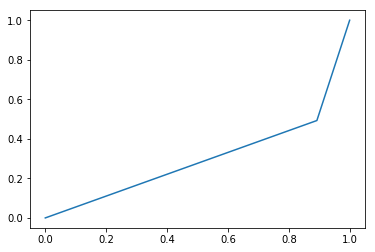

AUC: 0.3001911944531299


In [231]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_class_svm_2, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)


# Discussion

We can see that our change did not lead to a drastic improvement. Our changes might have better improvement with more distinct sets of data. We have a pretty high false positive range across all of them, which is a definite area of improvement. 

We do worse than he pure random decisions!